### Using Polar and Log-Polar Transformations for Registration
[link to example](https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_rotation.html#sphx-glr-auto-examples-registration-plot-register-rotation-py)

Phase correlation (`registration.phase_correlation`) is an efficient method for determining translation offset between pairs of similar images. However this approach telies on a near absence of rotation/scaling diffrences between the images, which are typical in real-world examples.

To recover rotation and scaling diffrences between two images, we can take advantage of two geometric properties of the log-polar transform and the translation invariance of the frequency domain. First, rotation in Cartesian space becomes translation along the angular cooridinate ($ \theta $) axis log-polar space. Second, scaling in Cartesian space becomes translation along the radial coordinate ($ \rho = \ln{\sqrt{x^2+y^2}}$) of log-polar space. Finally, differences in translation in the spatial domain do not impact magnitude spectrum in the frequency domain.

In this series of examples, we build on these concepts to show how the log-polar transform `transform.wrap_polar` can be used in conjunction with phase correlation to recover rotation and scaling diffrences between two images that also have a translation offset.

#### Recover rotation difference with a polar transform

In first example, we consider the simple case of two images that only differ with respect to rotation around a common center point. By remapping these images into polar space, the rotation difference becomes a simple translation difference that can be recovered by phase correlation.

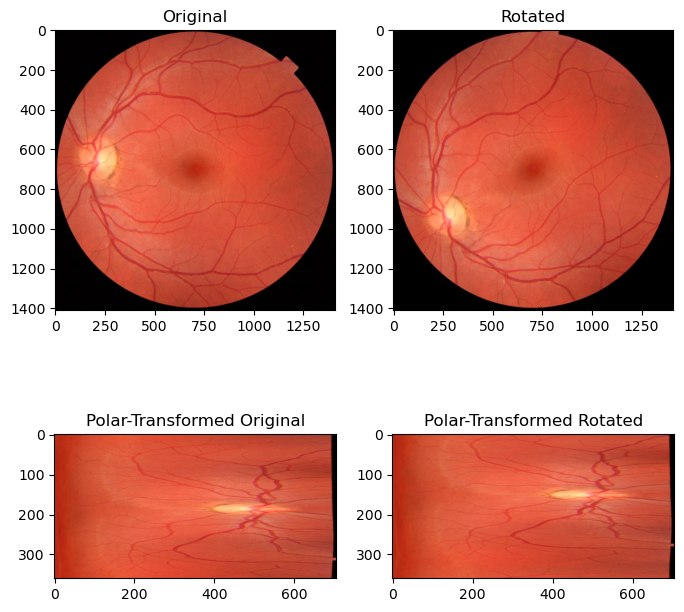

Expected value for counterclockwise rotation in degrees: 35
Recovered value for counterclockwise rotation: 35.0


In [25]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float

radius = 705
angle = 35
image = img_as_float(data.retina())
rotated = rotate(image, angle)
image_polar = warp_polar(image, radius=radius, channel_axis=-1)
rotated_polar = warp_polar(rotated, radius=radius, channel_axis=-1)

fig, axes = plt.subplots(2, 2, figsize=(8,8))
ax = axes.ravel()
ax[0].set_title("Original")
ax[0].imshow(image)
ax[1].set_title("Rotated")
ax[1].imshow(rotated)
ax[2].set_title("Polar-Transformed Original")
ax[2].imshow(image_polar)
ax[3].set_title("Polar-Transformed Rotated")
ax[3].imshow(rotated_polar)
plt.show()

shifts, error, phasediff = phase_cross_correlation(image_polar, rotated_polar)
print(f"Expected value for counterclockwise rotation in degrees: {angle}")
print(f"Recovered value for counterclockwise rotation: {shifts[0]}")

#### Register rotation and scaling on a translated image - Part 1
The above examples only work when the images to be registered share a center. However, it is more often the case that there is also a translation component to the diference between two images to be registered. One approach to register rotation, scaling and translation is to first correct for rotation and scaling, then solve for translation. It is possible to resolve rotation and scaling diffrences for translated images by working on the magnitude spectra of the Fourier-transformed images.

In this next example, we first show how the above approaches fail when two images differs by rotation, scaling and translation.

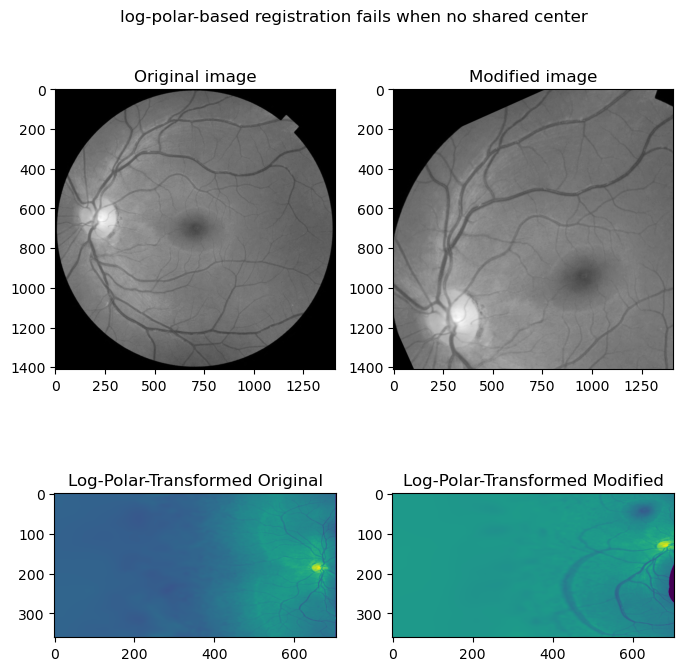

Expected value for cc rotation in degrees: 24
Recovered value for cc rotation: 9.05

Expected value for scaling diffrence: 1.4
Recovered value for scaling diffrence: 1.0476106934350098


In [26]:
from skimage.color import rgb2gray
from skimage.filters import window, difference_of_gaussians
from scipy.fft import fft2, fftshift

angle = 24
scale = 1.4
shiftr = 30
shiftc = 15

image = rgb2gray(data.retina())
translated = image[shiftr:, shiftc:]
rotated = rotate(translated, angle)
rescaled = rescale(rotated, scale)
sizer, sizec = image.shape
rts_image = rescaled[:sizer, :sizec]

# When center is not shared, log-polar transform in not helpful!
radius = 705
warped_image = warp_polar(image, radius=radius, scaling="log")
warped_rts = warp_polar(rts_image, radius=radius, scaling="log")
shifts, error, phasediff = phase_cross_correlation(warped_image, warped_rts, upsample_factor=20)

shiftr, shiftc = shifts[:2]
klog = radius / np.log(radius)
shift_scale = 1 / (np.exp(shiftc / klog))

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original image")
ax[0].imshow(image, cmap='gray')
ax[1].set_title("Modified image")
ax[1].imshow(rts_image, cmap='gray')
ax[2].set_title("Log-Polar-Transformed Original")
ax[2].imshow(warped_image)
ax[3].set_title("Log-Polar-Transformed Modified")
ax[3].imshow(warped_rts)
fig.suptitle('log-polar-based registration fails when no shared center')
plt.show()

print(f'Expected value for cc rotation in degrees: {angle}')
print(f'Recovered value for cc rotation: {shiftr}')
print()
print(f'Expected value for scaling diffrence: {scale}')
print(f'Recovered value for scaling diffrence: {shift_scale}')

#### Register rotation and scaling on a translated image - Part 2
We next whow how rotation and scaling differences, but not translation diffrences, are apparent in the frequency magnitude spectra of the images. These differences can be recovered by treating the magnitude spectra as images themselves, and applying the same log-polar + phase corellation approach taken above.

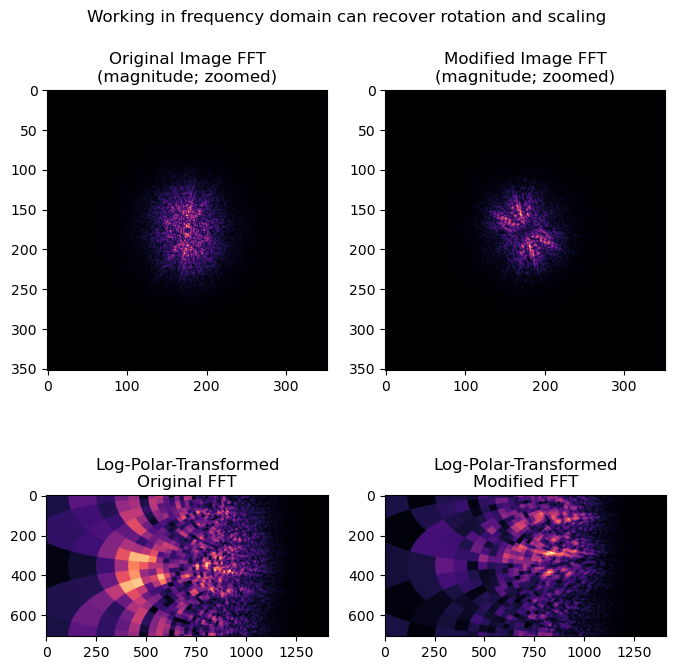

Expected value for cc rotation in degrees: 24
Recovered value for cc rotation: 0.05102763997165131

Expected value for scaling difference: 1.4
Recovered value for scaling difference: 0.46663985889861054


In [27]:
# First, band-pass filter both images
image = difference_of_gaussians(image, 5, 20)
rts_image = difference_of_gaussians(rts_image, 5, 20)

# window images
wimage = image * window('hann', image.shape)
rts_wimage = rts_image * window('hann', image.shape)

# work with shifted FFT magnitudes
image_fs = np.abs(fftshift(fft2(wimage)))
rts_fs = np.abs(fftshift(fft2(rts_wimage)))

# Create log-polar transformed FFT mag images and register
shape = image_fs.shape
radius = shape[0] // 8 # only take lower frequencies
warped_image_fs = warp_polar(image_fs, radius=radius, output_shape=shape, scaling='log', order=0)
warped_rts_fs = warp_polar(rts_fs, radius=radius, output_shape=shape, scaling='log', order=0)

warped_image_fs = warped_image_fs[:shape[0] // 2, :] # only use half of FFT
warped_rts_fs = warped_rts_fs[:shape[0] // 2, :]
shifts, error, phasediff = phase_cross_correlation(warped_image_fs, warped_rts_fs, upsample_factor=10)

# Use translation parameters to calculate rotation and scaling parameters
shiftr, shiftc = shifts[:2]
recovered_angle = (360 / shape[0]) * shiftr
klog = shape[1] / np.log(radius)
shift_scale = np.exp(shiftc / klog)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original Image FFT\n(magnitude; zoomed)")
center = np.array(shape) // 2
ax[0].imshow(image_fs[
    center[0] - radius:center[0] + radius,
    center[1] - radius:center[1] + radius
], cmap="magma")

ax[1].set_title("Modified Image FFT\n(magnitude; zoomed)")
ax[1].imshow(rts_fs[
    center[0] - radius:center[0] + radius,
    center[1] - radius:center[1] + radius
], cmap="magma")
ax[2].set_title("Log-Polar-Transformed\nOriginal FFT")
ax[2].imshow(warped_image_fs, cmap="magma")
ax[3].set_title("Log-Polar-Transformed\nModified FFT")
ax[3].imshow(warped_rts_fs, cmap="magma")
fig.suptitle("Working in frequency domain can recover rotation and scaling")
plt.show()

print(f'Expected value for cc rotation in degrees: {angle}')
print(f'Recovered value for cc rotation: {recovered_angle}')
print()
print(f'Expected value for scaling difference: {scale}')
print(f'Recovered value for scaling difference: {shift_scale}')

#### Some notes on this approach

1. The images should have some degree of bandpass filtering applied, particularly to remove high frequencies, and different choices here may impact outcome. The bandpass filter also complicates matters because images to be registered will differ in scale and these scale differences are unknown.

2. Images must be windowed using windows with circular symmetry, to remove the spectral leakage coming from image borders. There is no clearly optimal choice of window.